In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/208.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/473.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/333.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/45.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/369.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/56.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/89.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/20.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/275.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/212.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/239.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/58.jpg
/kaggle/input/cityscapes-image-pa

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from PIL import Image
from os.path import splitext

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
path='../input/cityscapes-image-pairs'
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    return images
images=images_upload(path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2975/2975 [00:00<00:00, 553497.80it/s]


In [4]:
images

['../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/208.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/473.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/333.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/45.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/369.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/56.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/89.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/20.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/275.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/212.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/239.jpg',
 '../input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/58.jpg',
 '../input/cityscapes-image-pairs/cityscapes_

In [5]:
def convert_image_rgb(data):
    imgs=[]
    for i in tqdm(data):
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        del i
        imgs.append(img)
    return imgs
img=convert_image_rgb(images)

100%|██████████| 6950/6950 [01:06<00:00, 105.11it/s]


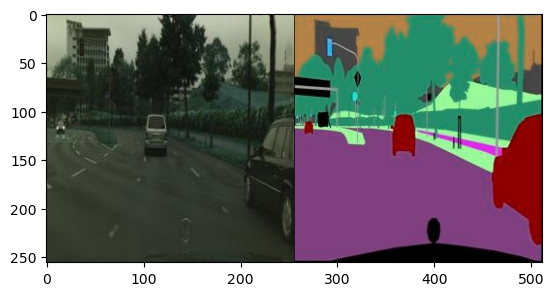

In [6]:
plt.imshow(img[np.random.randint(0,len(img))]);

In [7]:
def split_input_mask(data):
    inputs=[]
    mask=[]
    for i in data:
        a=i[:,:256]
        inputs.append(a)
        b=i[:,256:]
        mask.append(b)
    return inputs,mask
inputs,mask=split_input_mask(img)

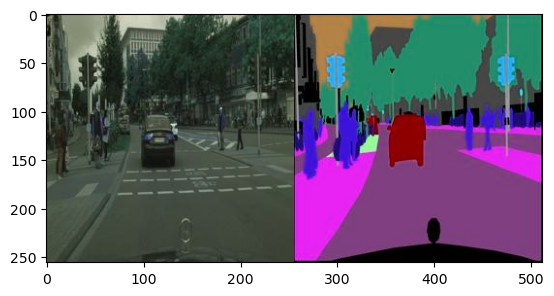

In [8]:
plt.imshow(img[110])

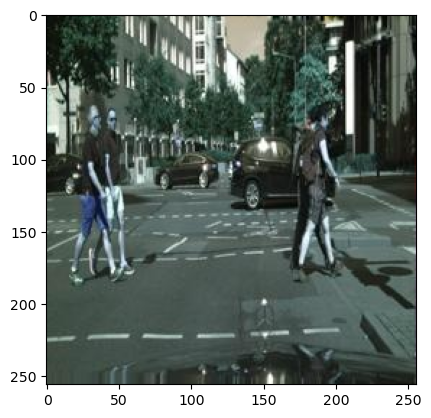

In [9]:
plt.imshow(inputs[100])

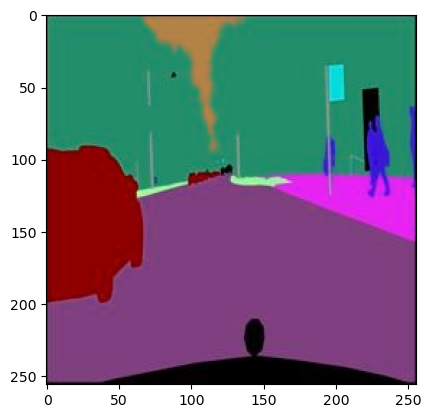

In [10]:
plt.imshow(mask[80])

In [11]:
def new_labels(mask):
    num_items = 1000
    color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
    num_classes = 10
    label_model = KMeans(n_clusters = num_classes)
    label_model.fit(color_array)
    labels=[]
    for i in tqdm(range(len(mask))):
        label_class = label_model.predict(mask[i].reshape(-1,3)).reshape(256,256)
        labels.append(label_class)
    return labels
labels=new_labels(mask)
idx=np.random.randint(0,len(labels))
classes,freq=np.unique(labels[idx],return_counts=True)
print(f'number of classes :{len(classes)}')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 6950/6950 [00:26<00:00, 259.98it/s]

number of classes :10


In [12]:
def rescale(data):
    rescaled=[]
    for i in tqdm(data):
        img=tf.image.convert_image_dtype(i, tf.float32)
        del i
        rescaled.append(img)
    return rescaled
rescaled_input=rescale(inputs)

100%|██████████| 6950/6950 [00:09<00:00, 720.73it/s] 


In [13]:
def build_model(inputsize=(256,256),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))
    
    conv = tfl.Conv2D(32, (3,3), padding="same",kernel_initializer='he_normal', name='Conv1')(inputs)
    
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLu()(x)
    x1 = tfl.Conv2D(32, (3,3), padding="same",kernel_initializer='he_normal', name='Conv2')(x)
    
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLu()(x)
    x= tfl.MaxPool2D(pool_size=(2,2), strides=(2,2), name='MaxPool1')(x)
    x= tfl.Conv2D(64, (3,3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x2= tfl.Conv2D(64, (3,3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLu()(x)
    x= tfl.MaxPool2D(pool_size=(2,2),name='MaxPool2')(x)
    x= tfl.Conv2D(128, (3,3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x3= tfl.Conv2D(128, (3,3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLu()(x)
    x= tfl.MaxPool2D(pool_size=(2,2),strides=(2,2), name='MaxPool3')(x)
    x= tfl.Conv2D(256, (3,3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x= tfl.Conv2D(256, (3,3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x= tfl.Conv2DTranspose(128, (3,3),strides=2, padding="same")(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    
    x=tfl.concatenate([x, x3], axis=3)
    x=tfl.Conv2D(128, (3,3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x=tfl.Conv2D(128, (3,3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x= tfl.Conv2DTranspose(64, (3,3),strides=2, padding="same")(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x=tfl.concatenate([x, x2], axis=3)
    x=tfl.Conv2D(64, (3,3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x=tfl.Conv2D(64, (3,3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x= tfl.Conv2DTranspose(32, (3,3),strides=2, padding="same")(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    
    x=tfl.concatenate([x, x1], axis=3)
    x=tfl.Conv2D(32, (3,3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    x=tfl.Conv2D(32, (3,3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLu()(x)
    
    outputs = tf1.Conv2D(classes, (1,1),padding="same", activation='softmax', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [14]:
def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(
        inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(
        x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='softmax', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [15]:
mymodel=build_model(classes=10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['Conv1[0][0]']                  
 alization)                     )                                                             

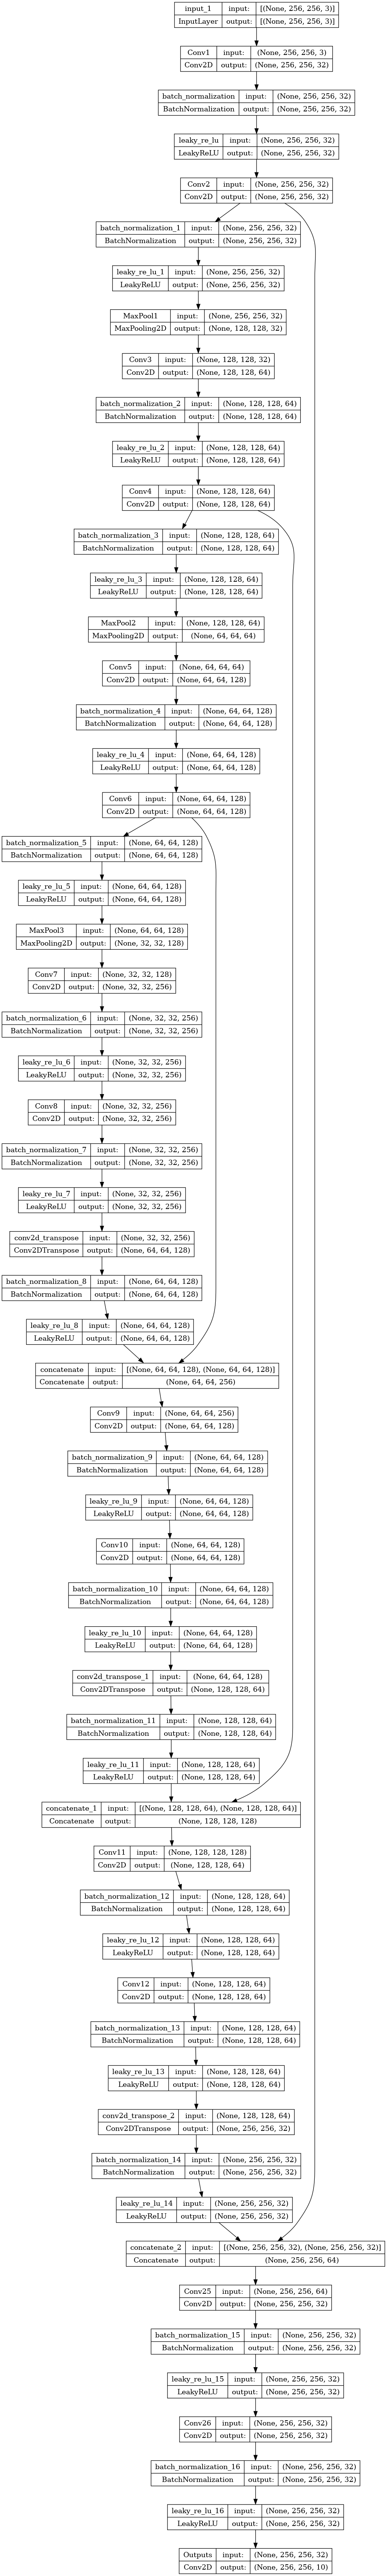

In [16]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(mymodel, to_file=img_file, show_shapes=True, show_layer_names=True)

In [17]:
def split_data(x,y,test_size=0.2):
    x1=np.array(x)
    del x
    y1=np.array(y)
    del y
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=test_size)
    return  x_train, x_test, y_train, y_test

In [18]:
x_train, x_test, y_train, y_test=split_data(rescaled_input[:1300],labels[:1300],test_size=0.2)

In [19]:
x_train.shape

(1040, 256, 256, 3)

In [20]:
y_train.shape

(1040, 256, 256)

In [21]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['acc'])
hist=mymodel.fit(x_train,y_train,batch_size=16,epochs=5)

Epoch 1/5
65/65 [==============================] - 55s 331ms/step - loss: 1.1777 - acc: 0.6025
Epoch 2/5
65/65 [==============================] - 22s 339ms/step - loss: 0.9041 - acc: 0.6902
Epoch 3/5
65/65 [==============================] - 23s 347ms/step - loss: 0.8367 - acc: 0.7145
Epoch 4/5
65/65 [==============================] - 23s 356ms/step - loss: 0.7859 - acc: 0.7327
Epoch 5/5
65/65 [==============================] - 24s 368ms/step - loss: 0.7595 - acc: 0.7435


In [22]:
def show_predications(x_test,y_test,y_pred):
    idx=np.random.randint(0,len(y_pred))
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].imshow(x_test[idx])
    axes[0].set_title("original")
    axes[1].imshow(y_test[idx])
    axes[1].set_title("mask")
    axes[2].imshow(y_pred[idx])
    axes[2].set_title("predicated")